# Testes com [Dask](https://dask.org/) em Python

Python é uma linguagem que une diferentes ferramentas para a ciência de dados, Dask é uma biblioteca em python para auxiliar a análise de grandes volumes de dados.

A programação paralela significa dividir o problema em partes separadas e unir as partes no final do processamento, Dask possui a escalabilidade existente no ecossistema python.

Os dados são divididos em chunks que podem ser manipulados indenpendentemente em paralelo.

In [94]:
from dask.distributed import Client
client = Client(n_workers = 4)

In [96]:
def fibonacci(n):
    if n < 3:
        return 1
    else:
        return fibonacci(n - 2) + fibonacci(n - 1)

In [97]:
from dask import delayed
from time import sleep
import time
import pandas as pd

In [98]:
%%time
# Serial

x = fibonacci(10)
y = fibonacci(20)
z = fibonacci(30)
soma = sum([x, y, z])

CPU times: user 141 ms, sys: 0 ns, total: 141 ms
Wall time: 140 ms


In [99]:
%%time
soma

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 17.4 µs


838860

In [100]:
%%time
# Paralelo, construção de um gráfico

x = delayed(fibonacci)(10)
y = delayed(fibonacci)(20)
z = delayed(fibonacci)(30)
soma = delayed(sum)([x,y,z])

CPU times: user 1.24 ms, sys: 0 ns, total: 1.24 ms
Wall time: 1.07 ms


In [101]:
%%time
# União dos dados partidos
soma.compute()

CPU times: user 11 ms, sys: 4.41 ms, total: 15.4 ms
Wall time: 149 ms


838860

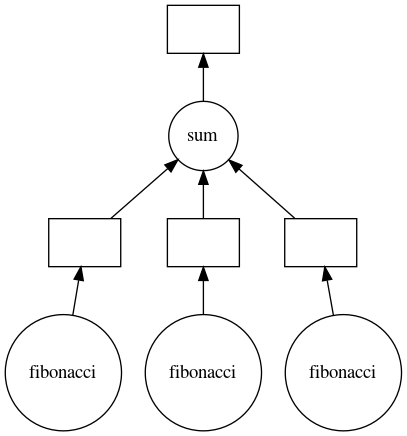

In [102]:
# Visulização dos processos partidos
soma.visualize()

## [Lei de Amdahl](https://pt.wikipedia.org/wiki/Lei_de_Amdahl)

   A lei de Amdahl, também conhecida como argumento de Amdahl, é usada para encontrar a máxima melhora esperada para um sistema em geral quando apenas uma única parte do mesmo é melhorada. Isto é frequentemente usado em computação paralela para prever o máximo speedup teórico usando múltiplos processadores.
  O speedup de um programa usando múltiplos processadores em computação paralela é limitado pelo tempo necessário para a fração sequencial de um programa. Por exemplo, se o programa precisa de 20 horas usando um único núcleo de processamento, e a parte específica de um programa que demora uma hora para executar não pode ser paralelizado, enquanto as 19 horas restantes (95%) do tempo da execução pode ser paralelizado, independente de quantos processadores são dedicados a execução paralela deste programa, o tempo de execução mínima não pode ser menor que aquela crítica uma hora. Por isso o aumento de velocidade é limitado em no máximo 20x.

In [128]:
# Criando um processo para o álculo do número de Amdahl
soma.compute()
exptimes = []

for cores in [1,2,4,8]: # Número de cores para a análise
    for trials in range(20):
        inicio = time.perf_counter()
        soma.compute(num_workers = cores)
        tempo = time.perf_counter() - inicio
        exptimes.append([cores, tempo])
        
df = pd.DataFrame(exptimes, columns = ["cores","time"])
df

,cores,time
0,1,0.012896
1,1,0.005197
2,1,0.005242
3,1,0.002872
4,1,0.002483
...,...,...
75,8,0.013758
76,8,0.013470
77,8,0.016135
78,8,0.011241


In [104]:
df.groupby('cores').describe()

time                                                              \
      count      mean       std       min       25%       50%       75%   
cores                                                                     
1      20.0  0.105480  0.076969  0.002408  0.004045  0.154983  0.162251   
2      20.0  0.111142  0.081401  0.002707  0.004453  0.158842  0.172407   
4      20.0  0.110721  0.072796  0.001993  0.003947  0.153418  0.157783   
8      20.0  0.108771  0.070759  0.002308  0.005723  0.152489  0.155357   

                 
            max  
cores            
1      0.171294  
2      0.191853  
4      0.179150  
8      0.158675

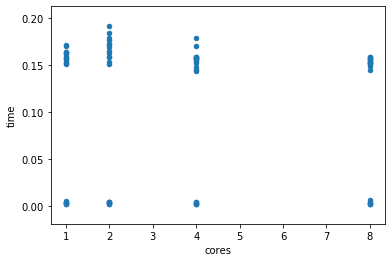

In [105]:
%matplotlib inline
df.plot(x = 'cores', y = 'time', kind = 'scatter')

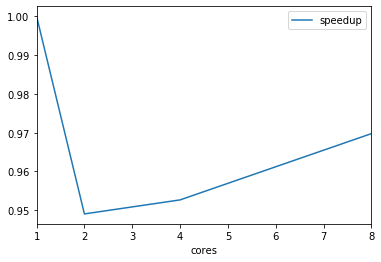

In [106]:
# Cálculo do Speedup de um processo
media = df.groupby('cores').mean()
media['speedup'] = media.loc[1].time / media['time']
media.plot(y = 'speedup', kind = 'line')

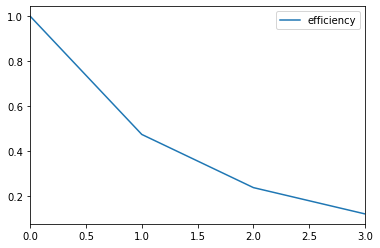

In [107]:
media.reset_index(inplace = True)
media['efficiency'] = media.loc[0].time / media['time'] / media['cores']
media.plot(y = ['efficiency'], kind = 'line');
# Essa linha é importante para a conversão em dados legíveis
df.reset_index(inplace = True)

In [108]:
media['amdahls_number'] = (media.cores/(media.cores-1)) * (1-1/media.speedup)
# Calculando o número de Amdahl
media

,cores,time,speedup,efficiency,amdahls_number
0,1,0.105480,1.000000,1.000000,NaN
1,2,0.111142,0.949062,0.474531,-0.107345
2,4,0.110721,0.952673,0.238168,-0.066238
3,8,0.108771,0.969750,0.121219,-0.035650


## Teste um pouco mais complexo

![this](https://upload.wikimedia.org/wikipedia/commons/e/ee/Binomial_tree.gif)

In [109]:
# Redução
def partition(lista):
    result = []
    if len(lista) % 2 == 0:
        i, lenght = 0, 2
        while lenght <= len(lista):
            result.append(lista[i:lenght])
            i, lenght = i + 2, lenght + 2
        return result
    else:
        pop = lista.pop()
        result = partition(lista)
        result.append([pop, 0])
        return result

def calculator(lista):
    soma = []
    for par in partition(lista):
        soma.append(int(par[0]) + int(par[1]))
    return soma        

def reduction(lista):
    if len(lista) == 1:
        return lista[0]
    else:
        aux = lista
        while len(aux) != 1:
            aux = calculator(aux)
        return aux[0]

In [110]:
%%time
lista = [2,3,5,1,7,6,8,4]
result = reduction(lista)

CPU times: user 13 µs, sys: 1 µs, total: 14 µs
Wall time: 18.6 µs


In [111]:
%%time
result

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


36

In [112]:
# Redução
def partition(lista):
    result = []
    if len(lista) % 2 == 0:
        i, lenght = 0, 2
        while lenght <= len(lista):
            result.append(lista[i:lenght])
            i, lenght = i + 2, lenght + 2
        return result
    else:
        pop = lista.pop()
        result = delayed(partition)(lista)
        result = result.compute()
        result.append([pop, 0])
        return result

def calculator(lista):
    soma = []
    var = delayed(partition)(lista)
    for par in var.compute():
        soma.append(int(par[0]) + int(par[1]))
    return soma

def reduction(lista):
    if len(lista) == 1:
        return lista[0]
    else:
        aux = lista
        while len(aux) != 1:
            calc = delayed(calculator)(aux)
            aux = calc.compute()
        return aux[0]

In [113]:
%%time
lista = [2,3,5,1,7,6,8,4]
soma = delayed(reduction)(lista)

CPU times: user 210 µs, sys: 0 ns, total: 210 µs
Wall time: 181 µs


In [114]:
%%time
soma.compute()

CPU times: user 38.5 ms, sys: 3.8 ms, total: 42.3 ms
Wall time: 111 ms


36

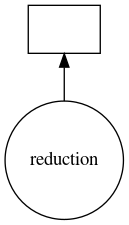

In [115]:
soma.visualize()

## Dask DataFrame

Semelhante ao vetores, Dask DataFrames são dados particionados no pandas, separados por Chunks e agregados novamente para a apresentação dos resultados. Possuem as seguintes propriedades:

- São dados Tabulares (duas dimensões);
- Cada coluna tem um tipo de dado definido pelo esquema;
- Queries são parecidas com SQL;
- Dados estruturados;

In [138]:
import dask.dataframe as dd

In [139]:
## Lendo os dados climatológicos da cidade de SJC em mm/dia Mensal
clim = dd.read_csv('prec4km_clim.csv', delimiter = ';', encoding = 'utf-8')
clim

,fid,execution_date,maxima,media,mes,pid_an_municip_monthly
npartitions=1,,,,,,
,int64,object,float64,float64,object,int64
,...,...,...,...,...,...


In [140]:
clim.compute()

,fid,execution_date,maxima,media,mes,pid_an_municip_monthly
0,5563,2018-01-31 02:00:00.717-02,8.952624,7.936766,Janeiro,1
1,5562,2018-01-31 02:00:00.717-02,8.271148,6.315904,Janeiro,2
2,5561,2018-01-31 02:00:00.717-02,NaN,NaN,Janeiro,3
3,5560,2018-01-31 02:00:00.717-02,2.598334,2.513348,Janeiro,4
4,5559,2018-01-31 02:00:00.717-02,2.489908,2.365603,Janeiro,5
...,...,...,...,...,...,...
66667,2653,2018-12-31 02:00:00-02,7.110368,6.863614,Dezembro,66668
66668,2654,2018-12-31 02:00:00-02,9.684531,8.779482,Dezembro,66669
66669,3829,2018-12-31 02:00:00-02,8.460323,8.405025,Dezembro,66670
66670,2650,2018-12-31 02:00:00-02,7.037047,6.680299,Dezembro,66671


In [141]:
## Lendo os dados climatológicos da cidade de SJC em mm/dia Mensal
municipios = dd.read_csv('municipios_brasil.csv', delimiter = ';', encoding = 'utf-8')
municipios

,fid,fid_1,sprarea,geocodigo,nome1,uf,id_uf,regiao,mesoregiao,microregia,latitude,longitude,sede,ogr_geometry
npartitions=1,,,,,,,,,,,,,,
,int64,int64,float64,int64,object,object,int64,object,object,object,float64,float64,int64,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [142]:
municipios.compute()

,fid,fid_1,sprarea,geocodigo,nome1,uf,id_uf,regiao,mesoregiao,microregia,latitude,longitude,sede,ogr_geometry
0,0,0,1.729391e+10,1200336,Mâncio Lima,AC,12,Norte,VALE DO JURUA,CRUZEIRO DO SUL,-7.614,-72.896,1,01060000200A1200000100000001030000000100000083...
1,1,1,2.400108e+11,1300201,Atalaia do Norte,AM,13,Norte,SUDOESTE AMAZONENSE,ALTO SOLIMOES,-4.372,-70.192,1,01060000200A12000001000000010300000001000000D9...
2,2,2,2.394642e+10,1301654,Guajará,AM,13,Norte,SUDOESTE AMAZONENSE,JURUA,-7.546,-72.584,1,01060000200A1200000100000001030000000100000086...
3,169,169,7.334175e+10,5102504,Cáceres,MT,51,Centro-Oeste,CENTRO-SUL MATO-GROSSENSE,ALTO PANTANAL,-16.071,-57.679,1,01060000200A120000010000000103000000010000008B...
4,4679,4679,4.950941e+08,2908200,Conceição da Feira,BA,29,Nordeste,CENTRO NORTE BAIANO,FEIRA DE SANTANA,-12.506,-38.999,1,01060000200A1200000100000001030000000100000017...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5551,5559,5559,2.061950e+08,2607604,Ilha de Itamaracá,PE,26,Nordeste,METROPOLITANA DE RECIFE,ITAMARACA,-7.748,-34.826,1,01060000200A1200000100000001030000000100000016...
5552,5560,5560,9.991505e+07,2503209,Cabedelo,PB,25,Nordeste,MATA PARAIBANA,JOAO PESSOA,-6.981,-34.834,1,01060000200A1200000200000001030000000100000012...
5553,5561,5561,5.625672e+07,2605459,Fernando de Noronha,PE,26,Nordeste,METROPOLITANA DE RECIFE,FERNANDO DE NORONHA,-3.840,-32.411,1,01060000200A120000010000000103000000010000001F...
5554,5562,5562,1.951001e+11,5003207,Corumbá,MS,50,Centro-Oeste,PANTANAL SUL MATO-GROSSENSE,BAIXO PANTANAL,-18.507,-54.760,1,01060000200A120000010000000103000000020000007F...


Qual a máxima e a média climatológica por mês no Município de SJC?

In [143]:
fid = int(municipios[municipios.nome1 == 'São José dos Campos']['fid'].compute())
sjc = clim[ clim.fid == fid ]
sjc.compute()

,fid,execution_date,maxima,media,mes,pid_an_municip_monthly
1932,2875,2018-01-31 02:00:00.717-02,8.344231,7.705591,Janeiro,1933
6708,2875,2018-02-28 03:00:00-03,6.662505,6.302007,Fevereiro,6709
13159,2875,2018-03-31 03:00:00-03,5.545661,5.011462,Março,13160
21500,2875,2018-04-30 03:00:00-03,2.536349,2.332118,Abril,21501
24271,2875,2018-05-31 03:00:00-03,1.974532,1.751176,Maio,24272
32612,2875,2018-06-30 03:00:00-03,1.712367,1.473090,Junho,32613
38168,2875,2018-07-31 03:00:00-03,1.800434,1.655272,Julho,38169
43724,2875,2018-08-31 03:00:00-03,1.091350,0.931052,Agosto,43725
46495,2875,2018-09-30 03:00:00-03,2.155687,1.865100,Setembro,46496
54836,2875,2018-10-31 03:00:00-03,4.270790,3.656610,Outubro,54837


Qual a máxima e a média climatológica no mês de Janeiro no Município de SJC?

In [144]:
sjc[sjc.mes == 'Janeiro'].compute()

,fid,execution_date,maxima,media,mes,pid_an_municip_monthly
1932,2875,2018-01-31 02:00:00.717-02,8.344231,7.705591,Janeiro,1933


In [146]:
%matplotlib inline
sjc.plot.hist(bins = 100)

AttributeError: 'DataFrame' object has no attribute 'plot'

In [124]:
client.close()